In [1]:
import numpy as np
import torch

torch.set_default_dtype(torch.float64)

import gpytorch

import pandas as pd

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("../data/housing.csv")

df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-117.08,32.70,37,2176,418.0,1301,375,2.8750,98900
1,-117.91,34.11,20,3158,684.0,2396,713,3.5250,153000
2,-117.10,32.75,11,2393,726.0,1905,711,1.3448,91300
3,-117.22,32.74,52,1260,202.0,555,209,7.2758,345200
4,-121.99,37.29,32,2930,481.0,1336,481,6.4631,344100
...,...,...,...,...,...,...,...,...,...
4995,-118.41,34.19,42,779,145.0,450,148,3.9792,193800
4996,-122.96,38.42,50,2530,524.0,940,361,2.9375,122900
4997,-118.00,33.77,24,1324,267.0,687,264,3.4327,192800
4998,-122.81,38.54,12,2289,611.0,919,540,1.1553,139300


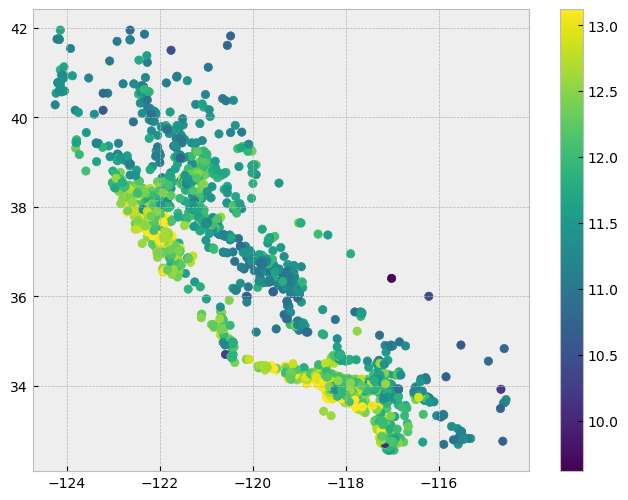

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(df.longitude, df.latitude, c=np.log(df.median_house_value))
plt.colorbar();

In [4]:
train_x = torch.from_numpy(df.drop(["median_house_value"], axis=1).values)
train_y = torch.from_numpy(df.median_house_value.values).log().to(train_x.dtype)

# normalize the labels
train_y = (train_y - train_y.mean()) / train_y.std()

# classical model

In [5]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-1)
)
model = GPModel(train_x, train_y, likelihood)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []

for i in tqdm(range(10)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())

    optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

# approximate model

In [7]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=inducing_points.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
# prepare data
num_datapoints = 100

torch.manual_seed(0)
model = ApproximateGPModel(
    train_x[torch.randint(train_x.shape[0], (num_datapoints,)), :]
)  # random samples
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-1)
)

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

# set up optimizers
ngd_optimizer = gpytorch.optim.NGD(
    model.variational_parameters(), num_data=train_y.size(0), lr=0.1
)
hyperparam_optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr=0.01
)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# train
model.train()
likelihood.train()

losses = []

for i in tqdm(range(10)):
    for x_batch, y_batch in train_loader:
        ngd_optimizer.zero_grad()

        output = model(x_batch)
        loss = -mll(output, y_batch)

        loss.backward()

        losses.append(loss.item())

        ngd_optimizer.step()
        hyperparam_optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]